In [145]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import feature
from skimage import external
import scipy
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy import stats
from scipy.optimize import least_squares
import cv2
import tifffile as tiff
import os
from scipy import signal
import time
from scipy.optimize import minimize
from scipy.stats import norm
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from matplotlib import cm
import argparse
import ast
from PIL import Image
import re

params = {'legend.fontsize': '22',
          'figure.figsize': (10, 8),
         'axes.labelsize': '22',
         'axes.titlesize':'22',
         'xtick.labelsize':'22',
         'ytick.labelsize':'22'}

folder = 'LASSENA_Calib/'

def getImageDescription(im): return ast.literal_eval(im.tag[270][0])
def getClockScalingFactor(): return (28/1000)/(1750000) 
def get_tiff_integration_time(im): return float(getImageDescription(im)["integration time"])*getClockScalingFactor()


#Going to use this to get rid of dodgy files with 0 integration time
#Courtesy of sam


def get_file_names(folder): #function returns ordered list of numbers of files in folder
    _, _, files = next(os.walk(folder))
    data = []
    #dark = []
    for file in files:
        try: 
            #file.replace(date,'')
            #file.replace(file_info,'')
            #file.replace(filetype,'')
            data.append(folder+'/'+file)
        except: continue
    return data
'''
def sort_folders(folders, batches = [],sorted_folders=[],file_info='pA_2x2cm_col',path='LASSENA_Calib/'):
    for folder in folders:
        folder = str(folder)
        folder = folder.replace(path,'')
        folder = folder.replace(file_info,'')
        folder = folder.replace(folder[folder.find('/'):],'')
        folder = folder.replace('[\'','')
        print(folder)
        batches.append(int(folder))
    batches = sorted(batches)
    batches = [str(batch) for batch in batches]
    sorted_folders = [batch.join(file_info) for batch in batches]
    return sorted_folders
'''      
    

def get_data_loc(folder): #function returns ordered list of numbers of files in folder
    _, folders,_ = next(os.walk(folder))
    fold,dark_fold,IsItOn,Myst = [],[],[],[]
    for subfolder in folders:
        if subfolder.count('dark')==1:
            dark_fold.append(get_file_names(folder+subfolder))
        elif subfolder.count('IsItOn')==1:
            IsItOn.append(get_file_names(folder+subfolder))
        elif subfolder.count('mystery')==1:
            Myst.append(get_file_names(folder+subfolder))
        elif subfolder.count('/.DS_Store')==0:
            fold.append(get_file_names(folder+subfolder))
        else:
            continue
        #fold = sort_folders(fold)
    return fold, dark_fold, IsItOn, Myst


def snip(image,chop=2): return np.array([l[chop:-chop-1] for l in image[chop:-chop-1]])
    #This chops L R U D chop number of elements (so Hough works)

def image_ret(file): return Image.open(file)
    #folder = 'LASSENA_Calib/'
    #filetype = '.tiff'
    #would add these commented sections into the imread part
    #inverted_img = np.invert(img)
    #am inverting and changing mm.tiff 
    #had to get rid of the snip bit for the tag to work

def roberts(image):
    Gx = signal.convolve(np.array([[1,0],[0,-1]]),image)
    Gy = signal.convolve(np.array([[0,1],[-1,0]]),image)
    G = np.sqrt(Gx**2+Gy**2)
    return snip(G)

def line_eqn(line): 
    x0,x1,y0,y1 = line
    m = (y1-y0)/(x1-x0)
    c = y0
    return [m,c]

def find_intercept(line1, line2):
    m1,c1 = line1
    m2,c2 = line2
    x = (c1-c2) / (m2-m1)
    y = m1 * x + c1
    return [x,y]  

def hough_grid(image,base_thresh=0,thresh_step=50,peaks=4,sep=200):
    #am changing thresh_step
    thresh = base_thresh
    tested_angles = np.linspace(-np.pi/2, np.pi/2, 360)
    base_image = roberts(image)
    image = np.where(base_image>thresh,1,0)
    plt.imshow(image,cm.gray)
    plt.show()
    h, theta, d = hough_line(image, theta=tested_angles)
    num_lines = len(hough_line_peaks(h, theta, d,min_distance=sep)[0])
    while num_lines != 4:
        print(num_lines)
        if num_lines == 0:
            raise Exception("Could not find 4 lines in image")
        thresh += thresh_step
        image = np.where(base_image>thresh,1,0)
        h, theta, d = hough_line(image, theta=tested_angles)
        num_lines = len(hough_line_peaks(h, theta, d,min_distance=sep)[0])
    plot_hough(h,theta,d)
    plt.imshow(image, cmap=cm.gray)
    origin = np.array((0, image.shape[1]))
    lines = ([])
    print(thresh)
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=sep,num_peaks=peaks)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        plt.plot(origin, (y0, y1), '-r')
        lines.append(line_eqn([origin[0],origin[1],y0,y1]))
    plt.xlim(origin)
    plt.ylim((image.shape[0],0))
    plt.title('Detected lines')
    plt.tight_layout()
    plt.show()
    print(lines)
    return lines

def cross_points(image,lines):
    #print(image.dtype)
    #print(lines.dtype)
    #takes lines and works out where they cross 
    #returns list of [x1,y1], [x2,y2]... of where points are
    done_list =([])
    pts = ([])
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i!=j and not any(point in done_list for point in [[i, j], [j, i]]):
                done_list.append([i,j])
                p1,p2 = find_intercept(lines[i],lines[j])
                if 0<p1<image.shape[0] and 0<p2<image.shape[1]:
                    pts.append([int(p1),int(p2)])
    sqr = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = np.sum(pts,axis = 1)
    sqr[0] = pts[np.argmin(s)]
    sqr[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    sqr[1] = pts[np.argmin(diff)]
    sqr[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return sqr



def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack individually
    rect = pts
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    #specifying points
    # top-left, top-right, bottom-right, and bottom-left
    sqr = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
        # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, sqr)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

def plot_hough(h,theta,d):
    plt.imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray,aspect=1/10)
    plt.title('Hough transform')
    plt.xlabel('Angles (degrees)')
    plt.ylabel('Distance (pixels)')
    plt.show()
    
def get_images(group): return np.array([np.asarray(image_ret(image)) for image in group])

def sum_pixel(images): return images.sum(axis=0)

def avg_bunch(group): 
    for image in group:
        if get_tiff_integration_time(image_ret(image)) ==0: 
            group.remove(image)
        else: continue
    stripped_images = get_images(group)
    #average of group of images
    #returns single value for bunch
    return stripped_images.mean(axis=0)

#np.array([image_ret(i) for i in bckr_count]).mean(axis=0)
     
def avg_img(images,img_mean=np.array([])): 
    for image in images:
        if get_tiff_integration_time(image_ret(image)) !=0: 
            np.append(img_mean,np.mean(np.asarray(image_ret(image))))
        else: continue
    #average of each individual image in a bunch
    #returns value for each indivdual image as a list for all the images
    return img_mean


def pixel_val(warped): #takes warped image and 
    in_avg, in_std= np.mean(warped),np.std(warped)/np.sqrt(len(warped))
    return ([in_avg,in_std])

#def file2num(file): return int(file[file.find('/')+1:file.find('p')])



#dark_img_folder = 'Define this folder'
#bckgr_count = get_file_nums(dark_img_folder)
#assumes the filename is the same as for normal files
#dark = avg_pv(bckgr_count)
data, dark, OnCheck,Myst = get_data_loc(folder)

#print(data[17])


In [146]:
dark_start = avg_bunch(dark[1])
dark_mid = avg_bunch(dark[0])
dark_end = avg_bunch(dark[2])

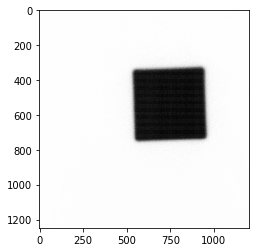

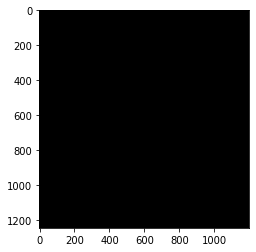

37
19
16
14
14
13
14
14
13
13
14
15
15
12
5


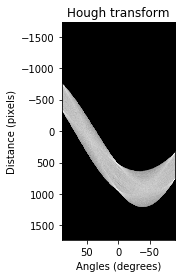

750


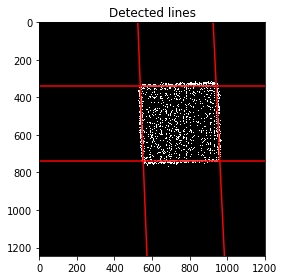

[[-4.7369515717340015e-17, 337.59762800115686], [20.760908494357448, -19221.270900370244], [-9.473903143468003e-17, 738.7136245299394], [25.380927575503588, -13301.070912028077]]
[[537. 337.]
 [942. 337.]
 [961. 738.]
 [553. 738.]]


In [147]:
img_for_roi = dark_start-avg_bunch(data[17])
plt.imshow(img_for_roi,cm.gray)
plt.show()
print(cross_points(img_for_roi,hough_grid(img_for_roi)))


Get dark subtract
    Dark_img = average bunch of dark images
Each image - Dark_img
Find Roi
    Put into Hough with largest dataset
    
Average images in bunch


In [ ]:
plt.imshow(avg_pv(dark[0])-avg_pv(dark[1]),cm.gray)
plt.title('Avg dark images PV at mid (3000pA) - Avg dark images PV at start (0pA)')
plt.show()
plt.imshow(avg_pv(dark[2])-avg_pv(dark[0]),cm.gray)
plt.title('Avg dark images PV at end (10500pA) - Avg dark images PV at mid (3000pA)')
plt.show()
plt.imshow(avg_pv(dark[2])-avg_pv(dark[1]),cm.gray)
plt.title('Avg dark images PV at end (10500pA) - Avg dark images PV at start (0pA)')
plt.show()
print('Avg dark 0pA PV {}'.format(np.mean(avg_pv(dark[1]))))
print('Avg dark 3000pA PV {}'.format(np.mean(avg_pv(dark[0]))))
print('Avg dark 10500pA PV {}'.format(np.mean(avg_pv(dark[2]))))